<a href="https://colab.research.google.com/github/sabeesh90/Layer_Fine_Tuning_Deep_Neural_Networks/blob/main/The_Lazarus_Trials_MobileNetV2_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing libraries

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import seaborn as sns
import warnings
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
!pip install -q -U keras-tuner
import kerastuner as kt
%load_ext tensorboard
warnings.filterwarnings("ignore")


     |████████████████████████████████| 97 kB 4.7 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
pip install Ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab Notebooks

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks


In [ ]:
classes = ['GALAXY', 'QSO', 'STAR']

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

class Metrics:
    # from sklearn
    def __init__(self, model, val_ds):
        self.val_ds = val_ds
        self.model = model
        self.prediction_classes = np.array([])
        self.true_classes = np.array([])
        
    def calculate_scores(self):     
        print('calculating score.....')   
        
        for x, y in self.val_ds:
            self.prediction_classes = np.concatenate([self.prediction_classes,np.argmax(self.model.predict(x), axis = -1)])
            self.true_classes = np.concatenate([self.true_classes, np.argmax(y.numpy(), axis=-1)])
        
        class_report = classification_report(self.true_classes, self.prediction_classes)
        conf_matrix = confusion_matrix(self.true_classes, self.prediction_classes)
        print(conf_matrix)
        print('------------------------------------')
        print(class_report)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

#### Densenet 121

##### Data preparation

In [ ]:
# Preprocessing the data
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 8


img_width_crop = 1024
img_height_crop = 1024

rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])


# augmenting the data
# cropless flip and rotate

data_aug_flip = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                # layers.experimental.preprocessing.RandomRotation(0.2)])
])

data_aug_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                layers.experimental.preprocessing.RandomRotation(0.2)])


# crop flip and rotate
data_aug_crop_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                                 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                                 layers.experimental.preprocessing.RandomRotation(0.2)])

data_aug_crop_flip = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

normal_crop = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512)],)
batch_size =32 
autotune = tf.data.AUTOTUNE

# Preparing the normal dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width_crop, img_height_crop), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width_crop, img_height_crop),
                                                                batch_size = batch_size, label_mode = 'categorical')


# preparing the scalred dataset
train_ds_scaled = train_ds.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled = val_ds.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)
train_ds.prefetch(buffer_size=autotune)
val_ds.prefetch(buffer_size=autotune)

train_ds_scaled_cropped = train_ds_scaled.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled_cropped = val_ds_scaled.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)

# augment function 
def prepare_dataset(ds, flip = False, flip_rotate = False):
    if flip == True:
        ds = ds.map(lambda x, y : (data_aug_flip(x, training = True), y), num_parallel_calls = autotune)
    elif flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)

def prepare_dataset_crop(ds, crop_flip = False, crop_flip_rotate = False):
    if crop_flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    elif crop_flip == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)
    
def prepare_dataset_normal_crop(ds, training = True):
    ds = ds.map(lambda x, y : (normal_crop(x, training = training), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
# 25 batches of 32 each and 7 batches of 32 each



Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.
Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


##### Densenet model building

In [ ]:
from tensorflow.keras.applications import  MobileNetV2
models = {'base_model'+str(num) : MobileNetV2(include_top=False, weights='imagenet', 
                                           input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg') for num in range(0,10)}

In [ ]:
models

{'base_model0': <keras.engine.functional.Functional at 0x7fc23d632e10>,
 'base_model1': <keras.engine.functional.Functional at 0x7fc4c59ea6d0>,
 'base_model2': <keras.engine.functional.Functional at 0x7fc24d71a490>,
 'base_model3': <keras.engine.functional.Functional at 0x7fc23cd15e10>,
 'base_model4': <keras.engine.functional.Functional at 0x7fc23cf38c90>,
 'base_model5': <keras.engine.functional.Functional at 0x7fc23d052110>,
 'base_model6': <keras.engine.functional.Functional at 0x7fc23cfb7e50>,
 'base_model7': <keras.engine.functional.Functional at 0x7fc4c52ba790>,
 'base_model8': <keras.engine.functional.Functional at 0x7fc4c4f20850>,
 'base_model9': <keras.engine.functional.Functional at 0x7fc4c4c85450>}

In [ ]:
layer_count  = len(models['base_model0'].layers)
print(f'There are a total of {layer_count} in the Densenet layer')

There are a total of 155 in the Densenet layer


In [ ]:
for model,value in models.items():
    print(model)

base_model0
base_model1
base_model2
base_model3
base_model4
base_model5
base_model6
base_model7
base_model8
base_model9


In [ ]:
num=0
for i, (model_name, model) in zip(range(155, -1,-5), models.items()):
    break_point  = i
    for layer in model.layers[0:break_point]:
        layer.trainable = False
    for layer in model.layers[break_point:]:
        layer.trainable = True
    input_layer = model.input
    output_layer = model.output
    x = Dense(num_classes, activation  = 'softmax')(output_layer)    
    models[model_name] = Model(inputs = input_layer, outputs = x)


In [ ]:
for model_name, model in models.items():
    count = 0
    trained_layers = ['a' if layer.trainable == True else None for layer in model.layers]
    print(f'The number of trainable layers in {model_name} is', trained_layers.count('a'), sep=':')

The number of trainable layers in base_model0 is:1
The number of trainable layers in base_model1 is:6
The number of trainable layers in base_model2 is:11
The number of trainable layers in base_model3 is:16
The number of trainable layers in base_model4 is:21
The number of trainable layers in base_model5 is:26
The number of trainable layers in base_model6 is:31
The number of trainable layers in base_model7 is:36
The number of trainable layers in base_model8 is:41
The number of trainable layers in base_model9 is:46


In [ ]:
# resnet_model.summary()
for model_name, model in models.items():
    model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

##### Densnet model with normalization of  image pixels

In [ ]:
models['base_model0'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 12s 332ms/step - loss: 1.9178 - accuracy: 0.3713 - val_loss: 1.1332 - val_accuracy: 0.4000
Epoch 2/60
25/25 [==============================] - 9s 291ms/step - loss: 1.6098 - accuracy: 0.3875 - val_loss: 1.0376 - val_accuracy: 0.5000
Epoch 3/60
25/25 [==============================] - 9s 291ms/step - loss: 1.5295 - accuracy: 0.5025 - val_loss: 1.0246 - val_accuracy: 0.4950
Epoch 4/60
25/25 [==============================] - 9s 289ms/step - loss: 1.4718 - accuracy: 0.5100 - val_loss: 1.0080 - val_accuracy: 0.4750
Epoch 5/60
25/25 [==============================] - 9s 291ms/step - loss: 1.4235 - accuracy: 0.5188 - val_loss: 0.9760 - val_accuracy: 0.5200
Epoch 6/60
25/25 [==============================] - 9s 291ms/step - loss: 1.3792 - accuracy: 0.5400 - val_loss: 0.9139 - val_accuracy: 0.5750
Epoch 7/60
25/25 [==============================] - 9s 291ms/step - loss: 1.3328 - accuracy: 0.5412 - val_loss: 0.9197 - val_accuracy: 0.5450
Epoch

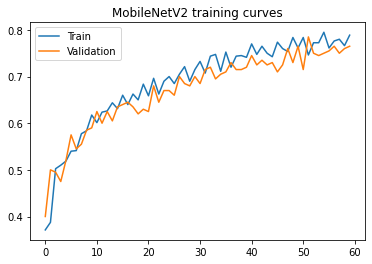

In [ ]:
plt.plot(models['base_model0'].history.history['accuracy'])
plt.plot(models['base_model0'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 12s 325ms/step - loss: 1.0979 - accuracy: 0.6587 - val_loss: 1.7694 - val_accuracy: 0.4000
Epoch 2/60
25/25 [==============================] - 9s 300ms/step - loss: 0.7214 - accuracy: 0.8525 - val_loss: 1.6918 - val_accuracy: 0.5100
Epoch 3/60
25/25 [==============================] - 9s 301ms/step - loss: 0.5854 - accuracy: 0.8775 - val_loss: 1.5679 - val_accuracy: 0.5550
Epoch 4/60
25/25 [==============================] - 9s 300ms/step - loss: 0.5183 - accuracy: 0.8950 - val_loss: 1.7359 - val_accuracy: 0.5500
Epoch 5/60
25/25 [==============================] - 9s 300ms/step - loss: 0.4646 - accuracy: 0.9050 - val_loss: 1.7443 - val_accuracy: 0.5550
Epoch 6/60
25/25 [==============================] - 9s 300ms/step - loss: 0.4278 - accuracy: 0.9125 - val_loss: 1.7233 - val_accuracy: 0.5600
Epoch 7/60
25/25 [==============================] - 9s 301ms/step - loss: 0.3806 - accuracy: 0.9225 - val_loss: 1.6975 - val_accuracy: 0.5750
Epoch

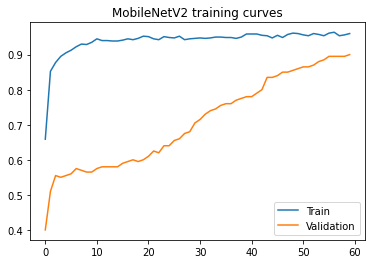

In [ ]:
models['base_model1'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model1'].history.history['accuracy'])
plt.plot(models['base_model1'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 12s 335ms/step - loss: 1.1236 - accuracy: 0.6363 - val_loss: 4.7769 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 9s 309ms/step - loss: 0.7040 - accuracy: 0.8200 - val_loss: 6.1036 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 9s 307ms/step - loss: 0.5472 - accuracy: 0.8813 - val_loss: 7.2929 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 9s 309ms/step - loss: 0.4489 - accuracy: 0.9112 - val_loss: 8.1333 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 9s 308ms/step - loss: 0.3889 - accuracy: 0.9212 - val_loss: 8.5151 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 9s 309ms/step - loss: 0.3345 - accuracy: 0.9362 - val_loss: 8.4488 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 9s 309ms/step - loss: 0.2837 - accuracy: 0.9400 - val_loss: 8.1443 - val_accuracy: 0.4800
Epoch

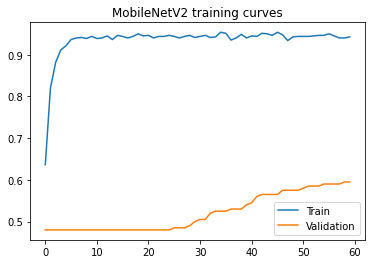

In [ ]:
models['base_model2'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model2'].history.history['accuracy'])
plt.plot(models['base_model2'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 12s 338ms/step - loss: 1.0885 - accuracy: 0.6837 - val_loss: 4.4447 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 9s 314ms/step - loss: 0.6078 - accuracy: 0.8637 - val_loss: 5.9758 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 9s 314ms/step - loss: 0.4065 - accuracy: 0.9087 - val_loss: 6.4761 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 9s 314ms/step - loss: 0.3291 - accuracy: 0.9388 - val_loss: 6.3766 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 9s 313ms/step - loss: 0.2865 - accuracy: 0.9337 - val_loss: 6.3897 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 9s 314ms/step - loss: 0.2065 - accuracy: 0.9600 - val_loss: 6.2795 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 9s 317ms/step - loss: 0.1607 - accuracy: 0.9563 - val_loss: 6.2282 - val_accuracy: 0.4800
Epoch

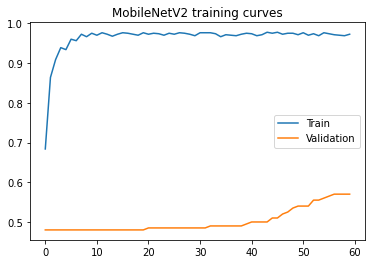

In [ ]:
models['base_model3'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model3'].history.history['accuracy'])
plt.plot(models['base_model3'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 13s 343ms/step - loss: 1.1618 - accuracy: 0.6237 - val_loss: 2.6981 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 9s 319ms/step - loss: 0.5579 - accuracy: 0.8925 - val_loss: 3.9850 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 9s 318ms/step - loss: 0.3693 - accuracy: 0.9237 - val_loss: 4.1378 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 9s 320ms/step - loss: 0.2554 - accuracy: 0.9425 - val_loss: 3.9014 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 9s 320ms/step - loss: 0.2128 - accuracy: 0.9513 - val_loss: 3.3673 - val_accuracy: 0.4850
Epoch 6/60
25/25 [==============================] - 9s 318ms/step - loss: 0.1688 - accuracy: 0.9613 - val_loss: 3.1924 - val_accuracy: 0.4850
Epoch 7/60
25/25 [==============================] - 9s 318ms/step - loss: 0.1451 - accuracy: 0.9825 - val_loss: 3.4143 - val_accuracy: 0.4850
Epoch

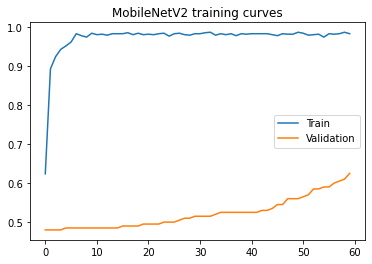

In [ ]:
models['base_model4'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model4'].history.history['accuracy'])
plt.plot(models['base_model4'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 12s 341ms/step - loss: 1.0565 - accuracy: 0.6812 - val_loss: 4.8251 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 9s 316ms/step - loss: 0.4681 - accuracy: 0.9000 - val_loss: 6.4584 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 9s 316ms/step - loss: 0.2761 - accuracy: 0.9350 - val_loss: 7.0050 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 9s 318ms/step - loss: 0.2078 - accuracy: 0.9563 - val_loss: 7.2276 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 9s 318ms/step - loss: 0.1317 - accuracy: 0.9712 - val_loss: 6.6079 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 9s 316ms/step - loss: 0.0938 - accuracy: 0.9775 - val_loss: 6.3669 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 9s 321ms/step - loss: 0.0632 - accuracy: 0.9862 - val_loss: 6.3822 - val_accuracy: 0.4800
Epoch

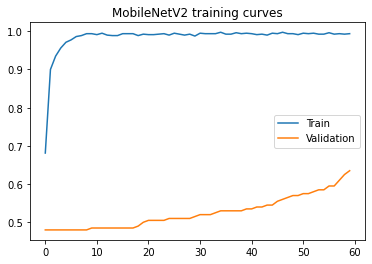

In [ ]:
models['base_model5'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model5'].history.history['accuracy'])
plt.plot(models['base_model5'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 13s 358ms/step - loss: 0.9975 - accuracy: 0.7225 - val_loss: 2.5064 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 10s 329ms/step - loss: 0.3879 - accuracy: 0.9287 - val_loss: 2.4371 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 10s 330ms/step - loss: 0.1891 - accuracy: 0.9613 - val_loss: 2.4182 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 10s 330ms/step - loss: 0.1116 - accuracy: 0.9812 - val_loss: 2.5091 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 10s 330ms/step - loss: 0.0664 - accuracy: 0.9900 - val_loss: 2.4043 - val_accuracy: 0.4750
Epoch 6/60
25/25 [==============================] - 10s 331ms/step - loss: 0.0538 - accuracy: 0.9875 - val_loss: 2.1070 - val_accuracy: 0.4750
Epoch 7/60
25/25 [==============================] - 10s 332ms/step - loss: 0.0308 - accuracy: 0.9962 - val_loss: 1.8281 - val_accuracy: 0.4800

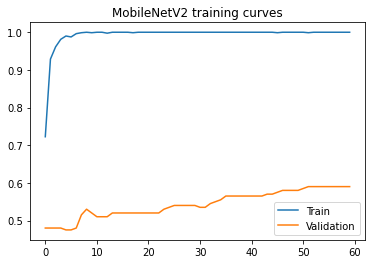

In [ ]:
models['base_model6'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model6'].history.history['accuracy'])
plt.plot(models['base_model6'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

In [ ]:
# second trial of 2,4, 8
from tensorflow.keras.applications import  MobileNetV2
models = {'base_model'+str(num) : MobileNetV2(include_top=False, weights='imagenet', 
                                           input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg') for num in range(0,4)}
num=0
for i, (model_name, model) in zip(range(154, -2,-2), models.items()):
    break_point  = i
    for layer in model.layers[0:break_point]:
        layer.trainable = False
    for layer in model.layers[break_point:]:
        layer.trainable = True
    input_layer = model.input
    output_layer = model.output
    x = Dense(num_classes, activation  = 'softmax')(output_layer)    
    models[model_name] = Model(inputs = input_layer, outputs = x)


for model_name, model in models.items():
    count = 0
    trained_layers = ['a' if layer.trainable == True else None for layer in model.layers]
    print(f'The number of trainable layers in {model_name} is', trained_layers.count('a'), sep=':')

    # resnet_model.summary()
for model_name, model in models.items():
    model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

The number of trainable layers in base_model0 is:2
The number of trainable layers in base_model1 is:4
The number of trainable layers in base_model2 is:6
The number of trainable layers in base_model3 is:8


Epoch 1/60
25/25 [==============================] - 12s 322ms/step - loss: 2.9076 - accuracy: 0.0600 - val_loss: 1.6699 - val_accuracy: 0.1400
Epoch 2/60
25/25 [==============================] - 9s 292ms/step - loss: 1.7907 - accuracy: 0.2837 - val_loss: 1.0648 - val_accuracy: 0.3900
Epoch 3/60
25/25 [==============================] - 9s 293ms/step - loss: 1.5697 - accuracy: 0.4450 - val_loss: 0.9927 - val_accuracy: 0.5100
Epoch 4/60
25/25 [==============================] - 9s 291ms/step - loss: 1.4934 - accuracy: 0.4825 - val_loss: 0.9807 - val_accuracy: 0.5200
Epoch 5/60
25/25 [==============================] - 9s 291ms/step - loss: 1.4361 - accuracy: 0.5362 - val_loss: 0.9330 - val_accuracy: 0.6000
Epoch 6/60
25/25 [==============================] - 9s 294ms/step - loss: 1.3856 - accuracy: 0.6363 - val_loss: 0.9025 - val_accuracy: 0.6200
Epoch 7/60
25/25 [==============================] - 9s 294ms/step - loss: 1.3421 - accuracy: 0.5925 - val_loss: 0.8928 - val_accuracy: 0.6200
Epoch

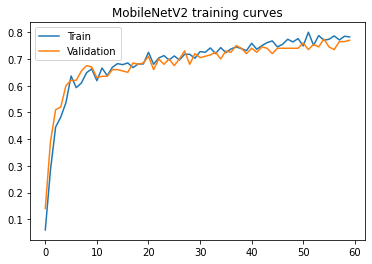

In [ ]:
models['base_model0'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model0'].history.history['accuracy'])
plt.plot(models['base_model0'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 12s 324ms/step - loss: 1.6999 - accuracy: 0.2362 - val_loss: 1.5661 - val_accuracy: 0.2050
Epoch 2/60
25/25 [==============================] - 9s 297ms/step - loss: 1.5591 - accuracy: 0.4363 - val_loss: 1.4692 - val_accuracy: 0.4700
Epoch 3/60
25/25 [==============================] - 9s 297ms/step - loss: 1.4556 - accuracy: 0.5750 - val_loss: 1.4800 - val_accuracy: 0.4750
Epoch 4/60
25/25 [==============================] - 9s 296ms/step - loss: 1.3738 - accuracy: 0.5900 - val_loss: 1.4714 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 9s 297ms/step - loss: 1.3094 - accuracy: 0.6488 - val_loss: 1.5287 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 9s 299ms/step - loss: 1.2585 - accuracy: 0.6625 - val_loss: 1.5533 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 9s 295ms/step - loss: 1.2110 - accuracy: 0.6425 - val_loss: 1.5905 - val_accuracy: 0.4800
Epoch

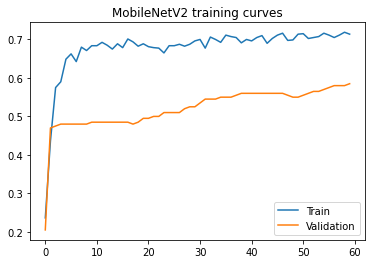

In [ ]:
models['base_model1'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model1'].history.history['accuracy'])
plt.plot(models['base_model1'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 12s 334ms/step - loss: 1.0153 - accuracy: 0.6975 - val_loss: 2.6214 - val_accuracy: 0.5200
Epoch 2/60
25/25 [==============================] - 9s 307ms/step - loss: 0.6929 - accuracy: 0.8475 - val_loss: 3.8760 - val_accuracy: 0.5150
Epoch 3/60
25/25 [==============================] - 9s 307ms/step - loss: 0.5458 - accuracy: 0.8712 - val_loss: 4.7348 - val_accuracy: 0.5250
Epoch 4/60
25/25 [==============================] - 9s 308ms/step - loss: 0.4521 - accuracy: 0.9050 - val_loss: 5.6113 - val_accuracy: 0.5250
Epoch 5/60
25/25 [==============================] - 9s 304ms/step - loss: 0.4129 - accuracy: 0.9150 - val_loss: 5.6036 - val_accuracy: 0.5250
Epoch 6/60
25/25 [==============================] - 9s 308ms/step - loss: 0.3617 - accuracy: 0.9225 - val_loss: 5.6191 - val_accuracy: 0.5500
Epoch 7/60
25/25 [==============================] - 9s 307ms/step - loss: 0.3148 - accuracy: 0.9500 - val_loss: 5.3367 - val_accuracy: 0.5550
Epoch

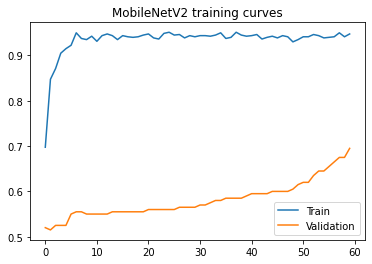

In [ ]:
models['base_model3'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model3'].history.history['accuracy'])
plt.plot(models['base_model3'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('MobileNetV2 training curves')
plt.show()

In [ ]:
i=0
for model_name, model in models.items():
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    
    print('base_model'+str(i),trainableParams,nonTrainableParams,totalParams)
    i+=1


base_model0 3843 2257984 2261827
base_model1 416643 1845184 2261827
base_model2 734403 1527424 2261827
base_model3 1043843 1217984 2261827
base_model4 1056323 1205504 2261827
base_model5 1363843 897984 2261827
base_model6 1529923 731904 2261827
base_model7 1628739 633088 2261827
base_model8 1685187 576640 2261827
base_model9 1747011 514816 2261827


In [ ]:
# second trial
i=0
for model_name, model in models.items():
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    
    print('base_model'+str(i),trainableParams,nonTrainableParams,totalParams)
    i+=1


base_model0 3843 2257984 2261827
base_model1 6403 2255424 2261827
base_model2 416643 1845184 2261827
base_model3 723843 1537984 2261827
